<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/a/a5/Font_Awesome_5_solid_car-crash.svg/1279px-Font_Awesome_5_solid_car-crash.svg.png" width="150" style="float: right;">

# Car accident severity prediction based on ML models

## Description of the problem and discussion of the background

Car crashes have risen to the 8th leading cause of death for people globally. 1.35 million people die in road accidents worldwide every year, that is **3700 deaths a day**.

Most accidents take place in the most busy roads, that people take everyday to go to and from work, on their daily commutes.

There are large records that describe the characteristics of each accident: road conditions, weather, vehicle, driver info (age, hours of sleep...), etc. For this project we will be working with some of these characteristics to predict the severity of an accident.

This predicion will make it possible to alert the drivers for the current risks so that they can avoid traveling in the current conditions.
This prediction will help the authoroties to better allocate resources, like police and medical emergency teams, according to the conditions that will make severe accidents more likely to happen in a certain area.

## Looking at the data and preparing it

The dataset we will use refers to accidents in Seattle city. Let's import and take a look at the dataset.

In [118]:
# import necessary libraries
import pandas as pd
import numpy as np

In [119]:
# loading the data from a CSV file to a dataframe
df = pd.read_csv(r'C:\Users\Desktop\Capstone\Data-Collisions.csv', low_memory=False)
df.columns # listing the columns available on the data

Index(['SEVERITYCODE', 'X', 'Y', 'OBJECTID', 'INCKEY', 'COLDETKEY', 'REPORTNO',
       'STATUS', 'ADDRTYPE', 'INTKEY', 'LOCATION', 'EXCEPTRSNCODE',
       'EXCEPTRSNDESC', 'SEVERITYCODE.1', 'SEVERITYDESC', 'COLLISIONTYPE',
       'PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', 'INCDATE',
       'INCDTTM', 'JUNCTIONTYPE', 'SDOT_COLCODE', 'SDOT_COLDESC',
       'INATTENTIONIND', 'UNDERINFL', 'WEATHER', 'ROADCOND', 'LIGHTCOND',
       'PEDROWNOTGRNT', 'SDOTCOLNUM', 'SPEEDING', 'ST_COLCODE', 'ST_COLDESC',
       'SEGLANEKEY', 'CROSSWALKKEY', 'HITPARKEDCAR'],
      dtype='object')

In [120]:
# sneak peek into the data as-is
df.head(3)

,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,...,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,2,-122.323148,47.703140,1,1307,1307,3502005,Matched,Intersection,37475.0,...,Wet,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N
1,1,-122.347294,47.647172,2,52200,52200,2607959,Matched,Block,NaN,...,Wet,Dark - Street Lights On,NaN,6354039.0,NaN,11,From same direction - both going straight - bo...,0,0,N
2,1,-122.334540,47.607871,3,26700,26700,1482393,Matched,Block,NaN,...,Dry,Daylight,NaN,4323031.0,NaN,32,One parked--one moving,0,0,N


The dataset has 38 columns, the first one being SEVERITYCODE.This column will be used as the target variable, as it is a measure of the severity of the accident. SEVERITYCODE varies between 1 and 2. These values represent the following consequences of the accident:

	1. Property Damage
	2. Injury

We will use the attributes WEATHER, ROADCOND and LIGHTCOND to predict the severity of an accident.

The original dataset needs some preparation to be fit for analysis. First, let's keep only the columns that will be used for the analysis.

In [121]:
# discarding unecessary columns that won't be used for the model
df.drop(['X', 'Y', 'OBJECTID', 'INCKEY', 'COLDETKEY', 'REPORTNO', 'STATUS', 'ADDRTYPE',
         'INTKEY', 'LOCATION', 'EXCEPTRSNCODE', 'EXCEPTRSNDESC', 'SEVERITYCODE.1',
         'SEVERITYDESC', 'COLLISIONTYPE', 'PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT',
         'VEHCOUNT', 'INCDATE', 'INCDTTM', 'JUNCTIONTYPE', 'SDOT_COLCODE', 'SDOT_COLDESC',
         'INATTENTIONIND', 'UNDERINFL', 'PEDROWNOTGRNT', 'SDOTCOLNUM', 'SPEEDING',
         'ST_COLCODE', 'ST_COLDESC', 'SEGLANEKEY', 'CROSSWALKKEY', 'HITPARKEDCAR'],
        axis=1, inplace=True)
df.head() # checking that only the necessary columns remain

,SEVERITYCODE,WEATHER,ROADCOND,LIGHTCOND
0,2,Overcast,Wet,Daylight
1,1,Raining,Wet,Dark - Street Lights On
2,1,Overcast,Dry,Daylight
3,1,Clear,Dry,Daylight
4,2,Raining,Wet,Daylight


In [122]:
def df_rows():
    print('Current number of rows: ', len(df)) # funciton for printing number of rows
    
df_rows()

Current number of rows:  194673


We have now around 195k rows of data, but we in order to train our model we need to expurgate the rows with useless data. Let's exclude the rows where there is no data for the three considered features (no value, or NaN) and also drop the lines where the features are 'Unknown'.

In [150]:
# dropping rows where any column has no data
df.dropna(how='any', inplace=True)

#dropping rows where any of the features is 'Unknown'
indexNames = df[(df['WEATHER'] == 'Unknown') | (df['ROADCOND'] == 'Unknown') | (df['LIGHTCOND'] == 'Unknown')].index
df.drop(indexNames , inplace=True)

In [151]:
df_rows()

Current number of rows:  170510


Let's now take a look at the type of our features.

In [152]:
# checking the type of each column
df.dtypes

SEVERITYCODE     int64
WEATHER         object
ROADCOND        object
LIGHTCOND       object
WEATHER_LE       int32
ROADCOND_LE      int32
LIGHTCOND_LE     int32
dtype: object

All three features are type 'object' and we need them to of a numerical type. These features need to be converted using label encoding, which will create several numerical columns, encoding the same data using integers.

In [153]:
# label encoding for object to numeric conversion
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
objList = df.select_dtypes(include = "object").columns

# new columns will be created with se suffix '_LE' for label encoded data
for feat in objList:
    df[feat+'_LE'] = le.fit_transform(df[feat].astype(str))

df.head()

,SEVERITYCODE,WEATHER,ROADCOND,LIGHTCOND,WEATHER_LE,ROADCOND_LE,LIGHTCOND_LE
0,2,Overcast,Wet,Daylight,4,7,5
1,1,Raining,Wet,Dark - Street Lights On,6,7,2
2,1,Overcast,Dry,Daylight,4,0,5
3,1,Clear,Dry,Daylight,1,0,5
4,2,Raining,Wet,Daylight,6,7,5


The seems all pretty and consistent, now. To make sure it is balanced, we will now check the representativity of the target variable.

In [154]:
# defining a function to check the balance
def balance(df):
    len_sev_1 = len(df[df['SEVERITYCODE'] == 1])
    len_sev_2 = len(df[df['SEVERITYCODE'] == 2])
    len_tot = len(df)

    print('SEVERITYCODE = 1', len_sev_1, '(', round(len_sev_1/len_tot*100, 1), '%)')
    print('SEVERITYCODE = 2', len_sev_2, '(', round(len_sev_2/len_tot*100, 1), '%)')
    
balance(df)

SEVERITYCODE = 1 114659 ( 67.2 %)
SEVERITYCODE = 2 55851 ( 32.8 %)


We notice a great unbalance in the target variable. Only about one third of the rows represent the higher severity accidents. We wish to have around 50% representation for each class. This can be fixed by dropping the majority class in order to achieve that ratio.

In [155]:
# finding the difference in the number of rows for each class
N = len(df[df['SEVERITYCODE'] == 1]) - len(df[df['SEVERITYCODE'] == 2])

# creating a DF with all the rows where SEVERITYCODE is 1 and drop its top N rows
df1 = df[df['SEVERITYCODE'] == 1]
df1.drop(df1.head(N).index , inplace=True)

df_final = pd.concat([df1, df[df['SEVERITYCODE'] == 2]])

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [156]:
balance(df_final)

SEVERITYCODE = 1 55851 ( 50.0 %)
SEVERITYCODE = 2 55851 ( 50.0 %)


We have now the final dataframe with the data ready to be used for our analysis.

Wish me luck! :)

# Methodology

The data looks now ready to be used by some machine learning models we will use to find any corelations between our variables.
We want to apply classification (predict if the accident severity if of degree 1 or 2), so we will test some suppervised learning models.

## Initialization

Let's initialize our models, defining X and y, normalizing the dataset, and creating a train and a test set before applying the models.

In [157]:
# defining X and y
X = np.asarray(df_final[['WEATHER_LE', 'ROADCOND_LE', 'LIGHTCOND_LE']])
y = np.asarray(df_final['SEVERITYCODE'])
X[0:15]
y[0:5]

array([1, 1, 1, 1, 1], dtype=int64)

Data Standardization give data zero mean and unit variance, it is good practice, especially for algorithms such as KNN which is based on distance of cases.

In [158]:
# normalizing the dataset
from sklearn import preprocessing
X = preprocessing.StandardScaler().fit(X).transform(X.astype(float))
X[0:5]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


array([[-0.70881467, -0.62815088,  0.59465842],
       [-0.70881467, -0.62815088,  0.59465842],
       [-0.70881467, -0.62815088,  0.59465842],
       [-0.70881467, -0.62815088, -1.50720646],
       [-0.70881467, -0.62815088,  0.59465842]])

We will use 80% of the data as a train set and 20% for testing.

In [159]:
# splitting the original dataset into train and test datasets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=7)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (89361, 3) (89361,)
Test set: (22341, 3) (22341,)


## K-Nearest Neighbor (KNN)

KNN will predict the severity of an accident (1 or 2) by looking for the most similar to data point within k distance.

In [133]:
# building the KNN Model
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

In [136]:
# finding the best K
Ks = 30
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    # train model and predict for different K's 
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

array([0.52171624, 0.52092656, 0.51912784, 0.50504519, 0.52013688,
       0.50465035, 0.5074581 , 0.50750197, 0.50710713, 0.50504519,
       0.51574976, 0.50741423, 0.52053172, 0.52004914, 0.51974204,
       0.52794595, 0.52851628, 0.52777047, 0.53027112, 0.51750461,
       0.51846977, 0.51860139, 0.51882074, 0.51803106, 0.51816267,
       0.51737299, 0.51715364, 0.51776783, 0.51789945])

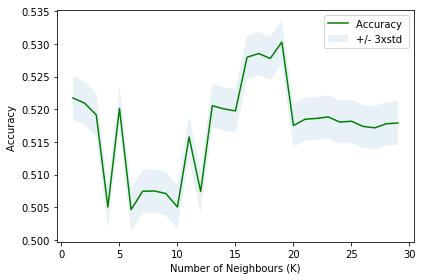

In [137]:
# plot model accuracy for Different number of Neighbors
import matplotlib.pyplot as plt
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbours (K)')
plt.tight_layout()
plt.show()


In [142]:
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1)
k = mean_acc.argmax()+1

The best accuracy was with 0.5302711239799948 with k= 19


Using the number of neighbours, K, that maximize the accuracy, let's train the model with the training data

In [143]:
# train the model with K=19 using the train set
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
#neigh = KNeighborsClassifier(n_neighbors = 19).fit(X_train,y_train)

Now we can use the trained model to predict the results in the test set. We can than compare the results of the prediction (yhat) with the real data of the test set (y_test) to measure accuracy.

In [144]:
# predict yhat in the test set
yhat_KNN = neigh.predict(X_test)
yhat_KNN[0:7]

array([1, 1, 2, 2, 2, 2, 2], dtype=int64)

In [145]:
# measuring the model's accuracy
print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat_KNN))

Train set Accuracy:  0.5308318343351028
Test set Accuracy:  0.5302711239799948


## Decision Tree

A decision tree model provides a representation of all possible outcomes given the different configurations of variables.

In [207]:
# building the DT Model
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
decTree = DecisionTreeClassifier(criterion="entropy", max_depth = 5)

In [208]:
# training the model
decTree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [209]:
# predicting the test set
yhat_DT = decTree.predict(X_test)
print (yhat_DT [0:7])
print (y_test [0:7])

[2 1 2 2 2 1 2]
[1 1 1 2 2 1 2]


In [210]:
# measuring the model's accuracy
import matplotlib.pyplot as plt
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_test, yhat_DT))

DecisionTrees's Accuracy:  0.5131372812318159


## Logistic Regression

Because the dataset only provides two severity code outcomes, the model will only predict one of those two classes. This makes the data binary, making logistic regression a perfect model to use.

In [255]:
# Modeling
from sklearn.linear_model import LogisticRegression
#from sklearn.metrics import confusion_matrix
LR = LogisticRegression(C=7, solver='liblinear').fit(X_train,y_train)
LR

LogisticRegression(C=7, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [256]:
yhat_LR = LR.predict(X_test)
yhat_LR

array([2, 1, 2, ..., 1, 2, 2], dtype=int64)

In [257]:
yhat_prob = LR.predict_proba(X_test)
yhat_prob

array([[0.48390127, 0.51609873],
       [0.53243565, 0.46756435],
       [0.49218433, 0.50781567],
       ...,
       [0.53243565, 0.46756435],
       [0.49218433, 0.50781567],
       [0.49218433, 0.50781567]])

## Results & Evaluation 

### K-Nearest Neighbour

In [108]:
# Jaccard index
from sklearn.metrics import jaccard_similarity_score
jaccard_similarity_score(y_test, yhat_KNN)

0.5264989763088622

In [109]:
# F1-score
from sklearn.metrics import f1_score
f1_score(y_test, yhat_KNN, average='weighted') 

0.4806235701948641

Model was found to be most accurate when k is 17.

### Decision Tree

In [211]:
# Jaccard index
from sklearn.metrics import jaccard_similarity_score
jaccard_similarity_score(y_test, yhat_DT)

0.5131372812318159

In [212]:
# F1-score
from sklearn.metrics import f1_score
f1_score(y_test, yhat_DT, average='weighted') 

0.466008552970871

Model was found to be most accurate with max depth of 5.

### Logistic Regression

In [258]:
# Jaccard index
from sklearn.metrics import jaccard_similarity_score
jaccard_similarity_score(y_test, yhat_LR)

0.5129134774629605

In [259]:
# F1-score
from sklearn.metrics import f1_score
f1_score(y_test, yhat_LR, average='macro') 

0.4906679056379535

In [260]:
from sklearn.metrics import log_loss
log_loss(y_test, yhat_prob)

0.6926235006706191

# Discussion

We started with unclean data and with a categorical dataset of type 'object'.
The data was thourghly clened and label encoding was used to created new classes that were numerical.
The resulting data was highly imbalanced, as class 1 was three times larger than class 2. The solution was to downsample the majority class.

The analyzed and cleaned data was used to feed three ML model: K-Nearest Neighbor, Decision Tree and Logistic Regression. Logistic Regression was the most promising model as its purpose is to deal with binary data as was the case of this dataset.

Evaluation metrics used to test the accuracy of these models were Jaccard index, F-1 score and Logloss for logistic regression. Choosing different k and max depth values helped to improve our accuracy to be the best possible.  Varying the hyparameter C of the LR model did not show any differences in accuracy metrics.

# Conclusion

Even though the accuracy of the models used was not too high, it shows that there is some degree of correlation between the considered values and the accident severity that can help predict if an accident will result in property damage or have worse consequences and cause injury.

Further study of the dataset could also take into account the location of the accidents in order to find out if some lenghts of the roads are better predictors of accident severity. Other features could be studied as well in future studies.